# Introduction :
<h2>Dataset
<h3> Imdb Dataset - Dataset contain Reviews given to movies and sentiment of the review.<br>
<h2> Metrics:
<h4>1. Accuracy<br>
<h4>2. Confusion Matrix<br>

<h3> Reference: - https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html <br>

<h3> Task :- <i> Train RNN model with pretrained Embedding Layer for Sentimental Analysis.</i>

<h5> APPROACHES -<br>
<t><h6>1) cleaning reviews.<br>
2) Tokenize reviews.<br>
3) Use pretrained embedding layer Word2Vec from Glove.<br>
4) Encode all the reviews word with Embedding Matrix.<br>
5) Define the model architecture with RNN.<br>
6) Training of Model.<br>
7) Plot Metrics.<br>


In [9]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import dataset
dataset = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
print(dataset.shape)
dataset.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# indexing the sentiment {'positive':1,'negative':1}
index_label = []
for sentiment in dataset['sentiment']:
  if sentiment =='positive':
    index_label.append(1)
  else:
    index_label.append(0)
dataset['sentiment'] = index_label

In [4]:
# Count number of Positive and Negative sentiment
print("Positive Label = ",dataset[dataset['sentiment'] == 1]['sentiment'].count())
print("Negative Label = ",dataset[dataset['sentiment'] ==0]['sentiment'].count())

Positive Label =  25000
Negative Label =  25000


This show that data is balance

In [5]:
#https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've","you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', ' while', 'of',
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under' , 'again', 'further', 
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'e ach', 'few', 'more', 
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll' , 'm', 'o', 're',
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "do esn't", 'hadn',
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
            'won', "won't", 'wouldn', "wouldn't"]

In [6]:
# Cleaning the sentence 
def cleaning_sentence(data):
  preprocessed_review = []
  for sentance in data: 
    # remove next line tag 
    sent = sentance.replace('\\n', ' ')
    # remove tab space 
    sent = sent.replace('\\t',' ')
    # remove html tags 
    sent = re.sub(r'<[^>]*>',"",sent)
    # put alphanumeric charater only
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280 
    sent = ' '.join(e for e in sent.split() if e not in stopwords) ## remove stopword 
    preprocessed_review.append(sent.lower().strip()) ## lowercase all the words.
  return preprocessed_review

In [7]:
# Cleans reviews
clean_text = cleaning_sentence(dataset['review'])

Max_word_len =  9470
Average word Length =  865.43264


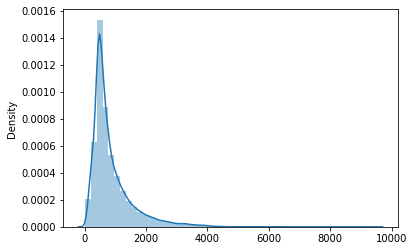

In [10]:
# To get average length of sentences in dataset
max_len =[]
for sent in clean_text:
  max_len.append(len(sent))
print("Max_word_len = ",max(max_len))
print("Average word Length = ",np.average(max_len))
sns.distplot(max_len)

In [31]:
# Tokenizing the sentences
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(clean_text)
sequences = tokenizer.texts_to_sequences(clean_text)

In [34]:
# Get word with their index for embedding 
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 103437 unique tokens.


In [35]:
## import pretrained Embedding Word2Vec 
embeddings_index = {}
f = open(os.path.join('/content/drive/MyDrive/glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [36]:
## Index the word with previous trained tokenizer to match with embedding word index
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [37]:
from  keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
## Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split( sequences,dataset['sentiment'].values, test_size=0.33, random_state=42)
print("Training dataset shape = ",len(X_train))
print("Test dataset shape = ",len(X_test))

Training dataset shape =  33500
Test dataset shape =  16500


In [38]:
# Add sequence to have same  length of input sequence
train_sent = pad_sequences(X_train, maxlen=200,padding = 'post')
test_sent = pad_sequences(X_test,maxlen = 200,padding = 'post')

print("Training Dataset shape = {},{}".format(train_sent.shape,y_train.shape))
print("Test Dataset shape = {},{}".format(test_sent.shape,y_test.shape))

Training Dataset shape = (33500, 200),(33500,)
Test Dataset shape = (16500, 200),(16500,)


In [68]:
## Defining model architecture
from keras.layers import Embedding,Input,Conv1D,MaxPooling1D,Dense,Flatten,LSTM,Dropout
from keras.models import Model

sequence_input = Input(shape=(200,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(32,return_sequences=True)(embedded_sequences)
x = Conv1D(128,5,activation = 'relu')(x)
x = MaxPooling1D(pool_size = 32)(x)
x = Flatten()(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 200, 100)          10343800  
_________________________________________________________________
lstm_9 (LSTM)                (None, 200, 32)           17024     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 196, 128)          20608     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 769 

In [69]:
## Training model
from keras.metrics import AUC
from keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
## Reduce learning rate by monitoring the val_loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=2, min_lr=0.0)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='acc')

model.fit(train_sent,y_train ,validation_data=(test_sent,y_test),
          epochs=10, batch_size=128,callbacks = [reduce_lr])

Epoch 1/10
262/262 [==============================] - 64s 237ms/step - loss: 0.5434 - acc: 0.7156 - val_loss: 0.3957 - val_acc: 0.8224
Epoch 2/10
262/262 [==============================] - 62s 236ms/step - loss: 0.3785 - acc: 0.8326 - val_loss: 0.3530 - val_acc: 0.8433
Epoch 3/10
262/262 [==============================] - 62s 237ms/step - loss: 0.3360 - acc: 0.8530 - val_loss: 0.3245 - val_acc: 0.8591
Epoch 4/10
262/262 [==============================] - 62s 236ms/step - loss: 0.3090 - acc: 0.8705 - val_loss: 0.3205 - val_acc: 0.8595
Epoch 5/10
262/262 [==============================] - 62s 236ms/step - loss: 0.2889 - acc: 0.8792 - val_loss: 0.3029 - val_acc: 0.8714
Epoch 6/10
262/262 [==============================] - 62s 237ms/step - loss: 0.2677 - acc: 0.8894 - val_loss: 0.3016 - val_acc: 0.8692
Epoch 7/10
262/262 [==============================] - 62s 236ms/step - loss: 0.2557 - acc: 0.8952 - val_loss: 0.2946 - val_acc: 0.8782
Epoch 8/10
262/262 [==============================] - 6

In [76]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## Define matrix 
def plot_confusionMatrix(predicted_y,true_y):
  # get confusion matrix
  data = confusion_matrix(true_y, predicted_y)
  # get recall matrix
  recall_mat = (((data.T)/(data.sum(axis=1))).T)
  # get precision Matrix
  precision_mat = (data/data.sum(axis=0))

  ## Plot the all the matrix 
  plt.figure(figsize=(20,4))
  cmap=sns.light_palette("blue")
  labels = ['positive','negative']
  plt.subplot(1, 3, 1)
  sns.heatmap(data, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Confusion matrix")
  
  plt.subplot(1, 3, 2)
  sns.heatmap(precision_mat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Precision matrix")
  plt.subplot(1, 3, 3) 

  sns.heatmap(recall_mat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Recall matrix")
  plt.show()

In [71]:
## Helper function 
## Convert percentage to positive sentiment to binary label 
def predict_label(sequences):
  pred = model.predict(sequences)
  prediction  = []
  for val in pred:
    if val>0.5:
      prediction.append(1)
    else:
      prediction.append(0)
  return prediction

train_pred = predict_label(train_sent)
test_pred = predict_label(test_sent)


## TRAIN 

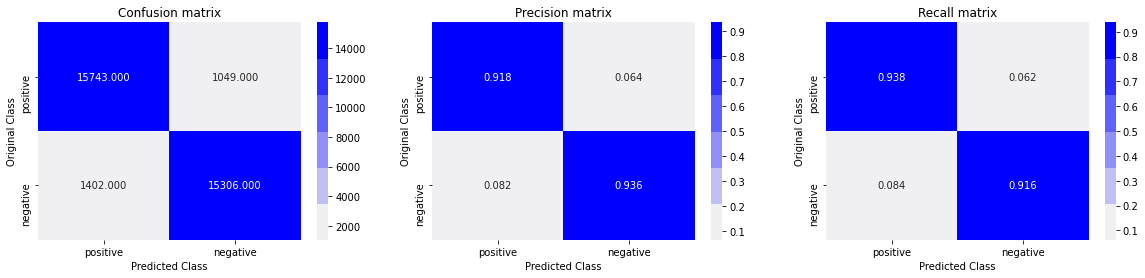

In [77]:
# Plot the matrix for training data
plot_confusionMatrix(train_pred,y_train)


## TEST

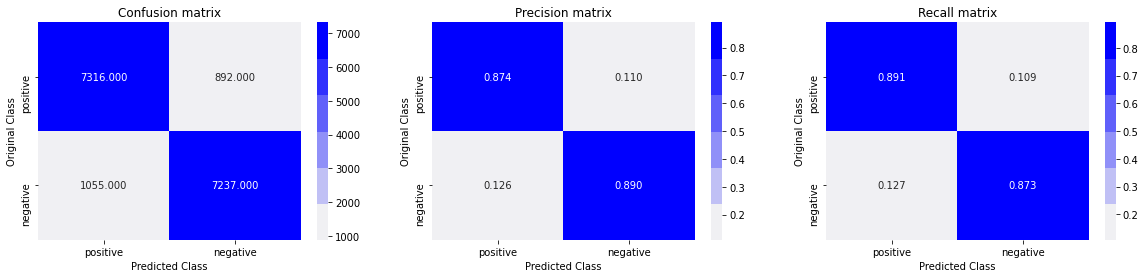

In [78]:
# Plot metric for test data 
plot_confusionMatrix(test_pred,y_test)
